# GloVe (Assignment)

Assignment Instruction

Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import time

In [2]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## 1. Load data

In [3]:
# Load tokeniser from SpaCy. I will use only small version.

tokenizer = spacy.load("en_core_web_sm")

In [4]:
#define corpus by using data that posted in classroom one.

corpus = []

with open('questions-words.txt') as f:
    while True:
        line = f.readline()
        if not line:
            break
        corpus.append(line.strip())
print(corpus[:5])
corpus_tokenized = []
for i in range(len(corpus)):
    corpus_tokenized.append([str(token) for token in tokenizer([c for c in corpus][i])])

[': capital-common-countries', 'Athens Greece Baghdad Iraq', 'Athens Greece Bangkok Thailand', 'Athens Greece Beijing China', 'Athens Greece Berlin Germany']


In [6]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Athens"]

531

In [7]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[50]

'write'

## 2. Prepare train data

In [8]:
skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent 
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = [word2index[sent[i-2]], word2index[sent[i+2]]]  # window_size = 2
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:30] 

[['-', 251],
 ['-', 86],
 ['common', 89],
 ['common', 118],
 ['-', 251],
 ['-', 86],
 ['in', 352],
 ['in', 500],
 ['-', 251],
 ['-', 86],
 ['adjective', 733],
 ['adjective', 115],
 ['-', 86],
 ['-', 86],
 ['to', 440],
 ['to', 625],
 ['-', 251],
 ['-', 86],
 ['present', 40],
 ['present', 933],
 ['-', 251],
 ['-', 86],
 ['nationality', 463],
 ['nationality', 440],
 ['-', 251],
 ['-', 86],
 ['past', 730],
 ['past', 77],
 ['-', 251],
 ['-', 86]]

In [9]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-2]], word2index[sent[i+2]]]  #window_size = 2
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [10]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[ 86],
       [733],
       [251],
       [ 86],
       [251],
       [ 86],
       [251],
       [352],
       [ 86],
       [251]])


## 3. Unigram distribution

In [11]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
# word_count # Showing word count

In [12]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

78244

In [13]:
z = 0.001  #scaling up low frequency terms
unigram_table = []

# create loop for the P(w) formula
for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** (3/4)
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

## 4. Negative sampling

In [14]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [15]:
import random

def negative_sampling(targets, unigram_table, k):
    
    batch_size = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)

In [16]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenized)

input_batch, label_batch

(array([[842],
        [325]]),
 array([[315],
        [ 89]]))

In [17]:
# Convert to Tensor

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [18]:
num_neg = 10  # I will try 10 as in the paper.
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [19]:
neg_samples.shape # shape is (batch_size, num_neg)

torch.Size([2, 10])

## 5. Model

In [20]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [21]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [22]:
emb_size = 10
voc_size = len(vocabs)
modelSkNeg = SkipgramNeg(voc_size, emb_size)

In [23]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [24]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [25]:
loss = modelSkNeg(input_tensor, label_tensor, neg_tensor)
loss

tensor(3.3764, grad_fn=<NegBackward0>)

## 6. Training

In [26]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelSkNeg      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(modelSkNeg.parameters(), lr=0.001)

In [27]:
Berlin = torch.LongTensor([word2index['Berlin']])
Berlin

tensor([355])

In [28]:
Berlin_center_embed = modelSkNeg.embedding_center_word(Berlin)
Berlin_outside_embed = modelSkNeg.embedding_outside_word(Berlin)

Berlin_embed = (Berlin_center_embed + Berlin_outside_embed) / 2
Berlin_embed

tensor([[-0.1825,  0.8305,  0.1201, -0.8326, -0.1171, -0.8626, -0.9466, -0.3102,
         -0.5444,  0.4586]], grad_fn=<DivBackward0>)

In [29]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelSkNeg.embedding_center_word(word)
    outside_embed = modelSkNeg.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [30]:
print(get_embed('Berlin'))

(-0.18253564834594727, 0.8304792642593384)


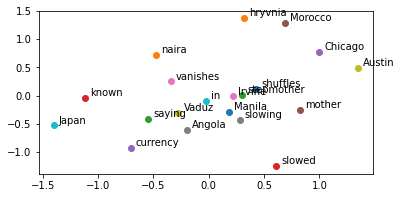

In [31]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Try on CBOW

In [36]:
#delete dupli Berlin word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Berlin"]

355

In [37]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[80]

'Malta'

## 7.1 Prepair train data

In [38]:
CBOW = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for o in outside_words:
            CBOW.append([center_word, o])

CBOW[:30] 

[['-', ':'],
 ['-', 'capital'],
 ['-', 'common'],
 ['-', '-'],
 ['common', 'capital'],
 ['common', '-'],
 ['common', '-'],
 ['common', 'countries'],
 ['-', ':'],
 ['-', 'city'],
 ['-', 'in'],
 ['-', '-'],
 ['in', 'city'],
 ['in', '-'],
 ['in', '-'],
 ['in', 'state'],
 ['-', ':'],
 ['-', 'gram1'],
 ['-', 'adjective'],
 ['-', '-'],
 ['adjective', 'gram1'],
 ['adjective', '-'],
 ['adjective', '-'],
 ['adjective', 'to'],
 ['-', '-'],
 ['-', 'adjective'],
 ['-', 'to'],
 ['-', '-'],
 ['to', 'adjective'],
 ['to', '-']]

In [39]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-2]], word2index[sent[i+2]]]  #window_size = 2
            
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [40]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[ 40],
       [ 86],
       [500],
       [ 86],
       [ 86],
       [251],
       [ 86],
       [251],
       [933],
       [ 89]])


## 7.2 Unigram distributution

In [41]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
# word_count # Showing word count

In [42]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

78244

In [43]:
z = 0.001  #scaling up low frequency terms
unigram_table = []

# create loop for the P(w) formula
for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** (3/4)
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

## 7.3 Negative sampling

In [44]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [45]:
import random

def negative_sampling(targets, unigram_table, k):
    
    batch_size = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)

In [47]:
batch_size = 2
label_batch, input_batch = random_batch(batch_size, corpus_tokenized)

input_batch, label_batch

(array([[ 86],
        [440]]),
 array([[ 86],
        [154]]))

In [48]:
# Convert to Tensor

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [49]:
num_neg = 10  
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [50]:
neg_samples.shape

torch.Size([2, 10])

In [58]:
class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [59]:
label, input = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [60]:
emb_size = 10 
voc_size = len(vocabs)
modelCB = CBOW(voc_size, emb_size)

In [61]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [62]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [63]:
loss = modelCB(input_tensor, label_tensor, neg_tensor)
loss

tensor(3.0097, grad_fn=<NegBackward0>)

## 7.4 Training

In [64]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelCB      = CBOW(voc_size, emb_size)

optimizer  = optim.Adam(modelCB.parameters(), lr=0.001)

In [65]:
num_epochs = 6000
startp = time.time()
for epoch in range(num_epochs):
    start = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = modelCB
    loss = modelCB(input_batch, label_batch, neg_batch)
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}mins {epoch_secs}secs")
endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}mins {secs}secs")

Epoch 1000 | Loss: 0.006699 | Time: 0mins 0secs
Epoch 2000 | Loss: 0.000531 | Time: 0mins 0secs
Epoch 3000 | Loss: 0.000167 | Time: 0mins 0secs
Epoch 4000 | Loss: 0.000000 | Time: 0mins 0secs
Epoch 5000 | Loss: 0.000000 | Time: 0mins 0secs
Epoch 6000 | Loss: 0.000000 | Time: 0mins 0secs
Process Time: 0mins 54secs


## 7.5 Plot the embeddings

In [66]:
Berlin = torch.LongTensor([word2index['Berlin']])
Berlin

tensor([355])

In [67]:
Berlin_center_embed = modelCB.embedding_center_word(Berlin)
Berlin_outside_embed = modelCB.embedding_outside_word(Berlin)

Berlin_embed = (Berlin_center_embed + Berlin_outside_embed) / 2
Berlin_embed

tensor([[-0.9341, -4.6931,  2.3916,  1.1021,  0.1182, -3.4221,  2.6224, -0.2901,
         -1.5478, -4.1145]], grad_fn=<DivBackward0>)

In [68]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelCB.embedding_center_word(word)
    outside_embed = modelCB.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [69]:
print(get_embed('Berlin'))

(-0.934106707572937, -4.693122386932373)


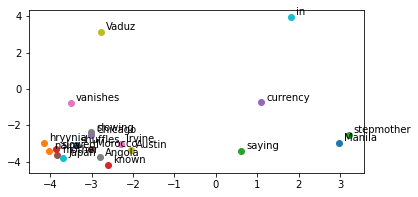

In [71]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 8. Normal Skipgram 

In [73]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Berlin"]

355

In [74]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[60]

'mostly'

In [75]:
skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = [word2index[sent[i-2]], word2index[sent[i+2]]]  #window_size = 2
        for o in outside_words:
            skipgrams.append([center_word, o])

In [79]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-2]], word2index[sent[i+2]]]  #window_size = 2
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [89]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [90]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[ 86],
       [625],
       [251],
       [440],
       [251],
       [733],
       [251],
       [ 86],
       [933],
       [352]])


## model

In [91]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 939])

In [92]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [93]:
emb_size = 10 
voc_size = len(vocabs)
modelSk = Skipgram(voc_size, emb_size)

In [97]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [98]:
loss = modelSk(input_tensor, label_tensor, all_vocabs)
loss

tensor(15.4560, grad_fn=<NegBackward0>)

## Training

In [99]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelSk      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(modelSk.parameters(), lr=0.001)

In [100]:
num_epochs = 4000 
startp = time.time()
#for epoch
for epoch in range(num_epochs):
    start = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    loss = modelSk(input_batch, label_batch, all_vocabs)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}mins {epoch_secs}secs")

endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}mins {secs}secs")

Epoch 1000 | Loss: 0.986033 | Time: 0mins 0secs
Epoch 2000 | Loss: 2.788755 | Time: 0mins 0secs
Epoch 3000 | Loss: 0.837506 | Time: 0mins 0secs
Epoch 4000 | Loss: 4.886400 | Time: 0mins 0secs
Process Time: 0mins 38secs


## Plot the embeddings

In [101]:
Berlin = torch.LongTensor([word2index['Berlin']])
Berlin

tensor([355])

In [102]:
Berlin_center_embed = modelSk.embedding_center_word(Berlin)
Berlin_outside_embed = modelSk.embedding_outside_word(Berlin)

Berlin_embed = (Berlin_center_embed + Berlin_outside_embed) / 2
Berlin_embed

tensor([[-2.8492, -1.4369,  0.7312, -0.3018, -2.3528, -1.1649, -2.0553, -2.6627,
         -0.3973,  1.7817]], grad_fn=<DivBackward0>)

In [104]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelSk.embedding_center_word(word)
    outside_embed = modelSk.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [105]:
print(get_embed('Berlin'))

(-2.849222421646118, -1.4369133710861206)


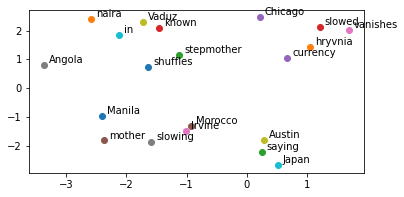

In [106]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 9. GloVe

In [107]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus_tokenized)))
vocab[:5]

['Manila', 'hryvnia', 'saying', 'known', 'Chicago']

In [108]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [109]:
#vocab size
voc_size = len(vocab)
print(voc_size)

938


In [110]:
#append UNK
vocab.append('<UNK>')

In [111]:
word2index['<UNK>'] = 0

In [112]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## Co-occurance matrix

In [113]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
# X_i

In [126]:
# Make skip gram of one size window
skip_grams = []

for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        target = sent[i]
        context = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for w in context:
            skip_grams.append((target, w))

skip_grams[:5]

[('-', ':'),
 ('-', 'capital'),
 ('-', 'common'),
 ('-', '-'),
 ('common', 'capital')]

In [127]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('-', ':'): 7,
         ('-', 'capital'): 1,
         ('-', 'common'): 1,
         ('-', '-'): 9,
         ('common', 'capital'): 1,
         ('common', '-'): 2,
         ('common', 'countries'): 1,
         ('-', 'city'): 1,
         ('-', 'in'): 1,
         ('in', 'city'): 1,
         ('in', '-'): 2,
         ('in', 'state'): 1,
         ('-', 'gram1'): 1,
         ('-', 'adjective'): 2,
         ('adjective', 'gram1'): 1,
         ('adjective', '-'): 2,
         ('adjective', 'to'): 1,
         ('-', 'to'): 1,
         ('to', 'adjective'): 1,
         ('to', '-'): 2,
         ('to', 'adverb'): 1,
         ('-', 'gram5'): 1,
         ('-', 'present'): 1,
         ('present', 'gram5'): 1,
         ('present', '-'): 2,
         ('present', 'participle'): 1,
         ('-', 'gram6'): 1,
         ('-', 'nationality'): 1,
         ('nationality', 'gram6'): 1,
         ('nationality', '-'): 2,
         ('nationality', 'adjective'): 1,
         ('-', 'gram7'): 1,
         ('-', 'pas

In [128]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [129]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Prepair train data

In [130]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

## Testing the method

In [131]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[439]
 [439]]
Target:  [[85]
 [85]]
Cooc:  [[1.09861229]
 [1.09861229]]
Weighting:  [[0.07208434]
 [0.07208434]]


## Model

In [132]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## Training

In [133]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
modelGl          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelGl.parameters(), lr=0.001)

In [134]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [135]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = modelGl(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}mins {epoch_secs}secs")

Epoch: 1000 | cost: 0.020811 | time: 0mins 0secs
Epoch: 2000 | cost: 0.097066 | time: 0mins 0secs
Epoch: 3000 | cost: 0.001189 | time: 0mins 0secs
Epoch: 4000 | cost: 0.001544 | time: 0mins 0secs
Epoch: 5000 | cost: 0.000010 | time: 0mins 0secs


In [136]:
#list of vocabs
vocab[:10]

['Manila',
 'hryvnia',
 'saying',
 'known',
 'Chicago',
 'mother',
 'vanishes',
 'slowing',
 'Austin',
 'in']

In [138]:
word = vocab[0]

In [139]:
#numericalization
id = word2index[word]
id

0

In [140]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [141]:
#get the embedding by averaging
v_embed = modelGl.embedding_v(id_tensor)
u_embed = modelGl.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 0.8327, -0.8458]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.0857,  0.8068]], grad_fn=<EmbeddingBackward0>))

In [142]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.0195, grad_fn=<SelectBackward0>)

In [143]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = modelGl.embedding_v(id_tensor)
    u_embed = modelGl.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

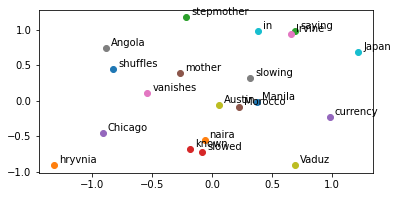

In [144]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### 10.  Comparing based on syntactic accuracy and semantic accuracy

In [147]:
corpus_tokenized[1:4]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China']]

In [148]:
modelSkNeg, modelSk, modelCB, modelGl

(SkipgramNeg(
   (embedding_center_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
   (logsigmoid): LogSigmoid()
 ),
 Skipgram(
   (embedding_center_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
 ),
 CBOW(
   (embedding_center_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
   (logsigmoid): LogSigmoid()
 ),
 GloVe(
   (embedding_v): Embedding(938, 2)
   (embedding_u): Embedding(938, 2)
   (v_bias): Embedding(938, 1)
   (u_bias): Embedding(938, 1)
 ))

In [150]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = word2index[sent[i-2]], word2index[sent[i+2]]  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [151]:
import math

def random_batchGl(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

## Syntactic accuracy

In [155]:
num_epochs = 4000
startp = time.time()
lossSk = 0
lossSkNeg = 0
lossCB = 0
lossGl = 0
batch_size = 2
#for epoch
for epoch in range(num_epochs):
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    input_batchG, target_batchG, cooc_batch, weighting_batch = random_batchGl(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batchG  = torch.LongTensor(input_batch)
    target_batchG = torch.LongTensor(target_batch)
    cooc_batch   = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    lossSk += modelSk(input_batch, label_batch, all_vocabs)
    lossSkNeg += modelSkNeg(input_batch, label_batch, all_vocabs)
    lossCB += modelCB(input_batch, label_batch, all_vocabs)
    lossGl += modelGl(input_batchG, target_batchG, cooc_batch, weighting_batch)
print(f'loss Skipgram: {lossSk/num_epochs}\nloss Skipgram Neg: {lossSkNeg/num_epochs}\nloss CBOW: {lossCB/num_epochs}\nloss GloVe: {lossGl/num_epochs}')

loss Skipgram: 34.515682220458984
loss Skipgram Neg: 8.156046867370605
loss CBOW: 91.04903411865234
loss GloVe: 0.14909549057483673


## Semantic accuracy

In [157]:
num_epochs = 4000
startp = time.time()
lossSk = 0
lossSkNeg = 0
lossCB = 0
lossGl = 0
batch_size = 2
#for epoch
for epoch in range(num_epochs):
    label_batch, input_batch  = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    target_batchG, input_batchG, cooc_batch, weighting_batch = random_batchGl(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batchG  = torch.LongTensor(input_batch)
    target_batchG = torch.LongTensor(target_batch)
    cooc_batch   = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    lossSk += modelSk(input_batch, label_batch, all_vocabs)
    lossSkNeg += modelSkNeg(input_batch, label_batch, all_vocabs)
    lossCB += modelCB(input_batch, label_batch, all_vocabs)
    lossGl += modelGl(input_batchG, target_batchG, cooc_batch, weighting_batch)
print(f'loss Skipgram: {lossSk/num_epochs}\nloss Skipgram Neg: {lossSkNeg/num_epochs}\nloss CBOW: {lossCB/num_epochs}\nloss GloVe: {lossGl/num_epochs}')

loss Skipgram: 26.93904685974121
loss Skipgram Neg: 22.328907012939453
loss CBOW: 1210.02734375
loss GloVe: 0.33704647421836853


||Syntactic|Semantic|
|:--|:--|:--|
|Skipgram|34.515682220458984|26.93904685974121|
|Skipgram Neg|8.156046867370605|22.328907012939453|
|CBOW|91.04903411865234|1210.02734375|
|GloVe|0.14909549057483673|0.33704647421836853|

From the experiments, all of loss of syntactic accuracy are less than semantic accuracy. There have drastically loss of semantic accuracy at CBOW compared with synrtactic accuracy, maybe it caused of random batch errors.